# Housing Agent Model based on Geographic distances

In [ ]:

# Import necessary libraries
import numpy as np
import geopandas as gpd
import osmnx as ox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import housing_model_functions as hm  # Python file with all functions
import warnings
from itertools import permutations

warnings.filterwarnings('ignore')

## Define City and District data

### Data Imports (OSMNX)

In [2]:
warnings.filterwarnings('ignore')

# Define New York City as city to be analyzed
place_name = "New York City"

# OSMNX Public data downloads:

# Download district borders. Here make sure admin level matches district level by observing borders df
borders = ox.features_from_place(place_name, tags={"boundary": "administrative", "admin_level": "8"})

# Probably there will be repeated districts in the df so just select the desired ones with a similar method as below. Perhaps changing 'ref' column name and the end of range to num of districts + 1.
districts_within_city = borders[borders['name'].isin(['The Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])]

# Gets city boundary
city_boundary = ox.geocode_to_gdf(place_name, which_result = 1) 

# Gets districts within city boundary
districts_within_city = gpd.sjoin(districts_within_city, city_boundary, how = "inner", predicate = 'within')
districts_within_city = districts_within_city[['name_left', 'geometry']].rename(columns={'name_left': 'District'})

# Download the road network data and Convert to GeoDataFrame for easier manipulation
road_df = ox.graph_from_place(place_name, network_type = "drive")
road_df = ox.graph_to_gdfs(road_df, nodes = False)

# Download parks (Only include named parks with polygon and multipolygon shapes to reduce amenity saturation)
parks = ox.features_from_place(place_name, tags = {"leisure" : "park"})
parks = parks[parks.geometry.type.isin(['Polygon', 'MultiPolygon'])]
parks = parks[~parks['name'].isna()]
parks = parks[['geometry']]
parks['Type'] = 'park'

# Download schools
schools = ox.features_from_place(place_name, tags = {'amenity' : 'school'})
schools = schools[['geometry']]
schools['Type'] = 'school'

# Download supermarkets
supermarkets = ox.features_from_place(place_name, tags = {'shop' : 'supermarket'})
supermarkets = supermarkets[['geometry']]
supermarkets['Type'] = 'supermarket'

# Download landmarks
landmarks = ox.features_from_place(place_name, tags = {'tourism' : ['attraction', 'gallery', 'artwork', 'viewpoint']})
landmarks = landmarks[['geometry']]
landmarks['Type'] = 'landmark'

# Create joint amenity DataFrame
amenities_df = pd.concat([parks, schools, supermarkets, landmarks], axis=0)
amenities_df = gpd.sjoin(amenities_df, districts_within_city, how = "left", predicate = 'within')
amenities_df = amenities_df.rename(columns={'name_left': 'District'})
amenities_df = amenities_df.dropna(subset=['geometry', 'Type', 'District'])
amenities_df = amenities_df[['geometry', 'Type', 'District']]

# Download residential areas
residential_areas = ox.features_from_place(
    place_name, tags = {'building': ['apartments', 'bungalow', 'cabin', 'detached', 'annexe', 'farm', 'house', 'houseboat', 'residential', 'semidetached_house', 'terrace']})
residential_areas = gpd.GeoDataFrame(residential_areas['geometry'])
residential_areas = gpd.sjoin(residential_areas, districts_within_city, how = "inner", predicate = 'within')
residential_areas = residential_areas[['geometry', 'District']]

# Following Lines are necessary for accurate centroid calculation for agent placing

# Convert Residential from coordinate to metric system. Note: epsg defines the coordinate system we want to use.
projected_residence = residential_areas.to_crs(epsg=2263)

# Extract centroids from the geometry column for comparison
projected_residence['centroid'] = projected_residence['geometry'].centroid
projected_residence = projected_residence[['centroid', 'District']]

# Convert centroids back to geographic coordinates 
projected_residence = projected_residence['centroid'].to_crs(epsg=4326)
projected_residence = gpd.GeoDataFrame(projected_residence)

# Extract latitude and longitude from centroids
projected_residence[['latitude', 'longitude']] = projected_residence['centroid'].apply(
                lambda point: pd.Series([point.y, point.x])
            )
projected_residence['District'] = residential_areas['District']

# Reduce the data to only necessary columns and reset index 
residences_reduced = projected_residence[['latitude', 'longitude', 'District']]
residences_reduced = residences_reduced.reset_index(drop=True)

### Data Imports (From Researched Data Excel)

In [3]:
# Researched Price Data Import:

# Import NYC data from auxiliary excel file. Ensure excel file is in same folder as code.
file_name = "NYC_data.xlsx"

# Import Borough Price Data
yearly_prices = pd.read_excel(file_name, sheet_name= 'Price Data' ,index_col = 0)

# Import Population Data
population = pd.read_excel(file_name, sheet_name= 'Population Data' ,index_col = 0)

# Import Income Data
income = pd.read_excel(file_name, sheet_name= 'Income Data')

# Import Housing Growth Data
growth_rate = pd.read_excel(file_name, sheet_name= 'Housing Growth (2017-2021)' ,index_col = 0)

# Adapt population and income dataframes to work with model
population, income = hm.model_conversions(population,income)

# Determining optimal parameters

## Testing Convergence, Choice of Num_iterations

In [ ]:
# Set arbitrary year for testing
year = 2018
median_price = np.median(yearly_prices.loc[year]) 
# Affluence group parameters 
affluence_vals = np.array(income.iloc[:,0])

# Initial affluence proportions   
affluence_dist = np.array(income.iloc[:,1])
 
# Specify the number of agents and amenities to be placed
num_agents = 1000 
num_amenities = 200

# Set inflationary weights for agents and amenities
weight = 0.8

districts = list(yearly_prices.columns) 

amenity_multiplier = {
    'park': .1* median_price,
    'school': .2 * median_price,
    'supermarket': .4 * median_price,
    'landmark': .2 * median_price
}
  
# Initialize results array and set largest iteration limit
iteration_limit = 100
iteration_tests_same = np.zeros((iteration_limit, len(districts)))   

# Call initialize function
model_agents, model_amenities, radius, radius_amenity = hm.grid_initializer(num_agents, num_amenities, population, affluence_vals, affluence_dist, residences_reduced, amenities_df)

# Initialize prices
initial_prices = hm.initial_price_dist(model_agents, year, yearly_prices)
for k, district in enumerate(districts):
    # Select residences within each district
    initial_prices_k = initial_prices[initial_prices['District'] == district]
    iteration_tests_same[0, k] = np.average(initial_prices_k['price'])
 # Do the first house values calculation
vals = hm.update_house_prices(initial_prices, weight, radius , model_amenities, amenity_multiplier, radius_amenity)
for k, district in enumerate(districts):
    # Select residences within each district
    vals_k = vals[vals['District'] == district]
    iteration_tests_same[1, k] = np.average(vals_k['price'])

# Do remaining evaluations             
for i in range(2, iteration_limit):
    vals,_, swap_tot = hm.new_iteration(vals, weight, radius , model_amenities, amenity_multiplier, radius_amenity)   
    for k, district in enumerate(districts):
        # Select residences within each district
        vals_k = vals[vals['District'] == district]
        iteration_tests_same[i, k] = np.average(vals_k['price'])


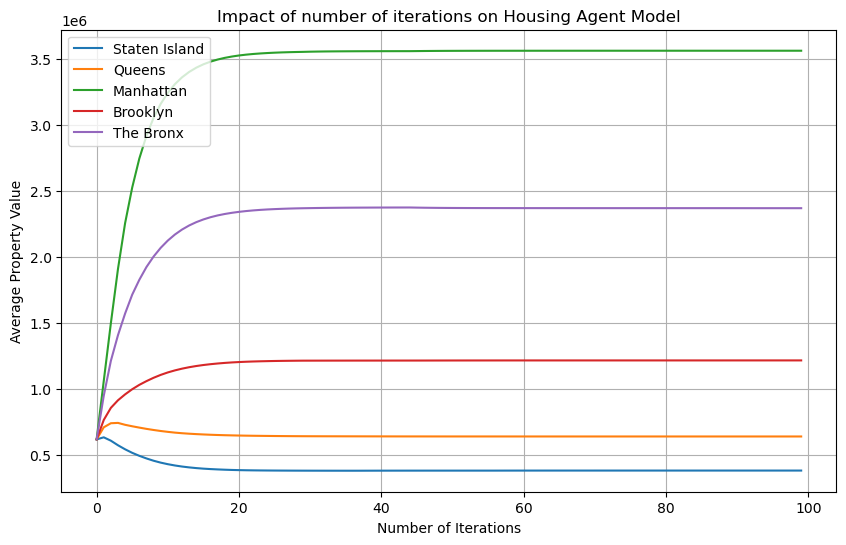

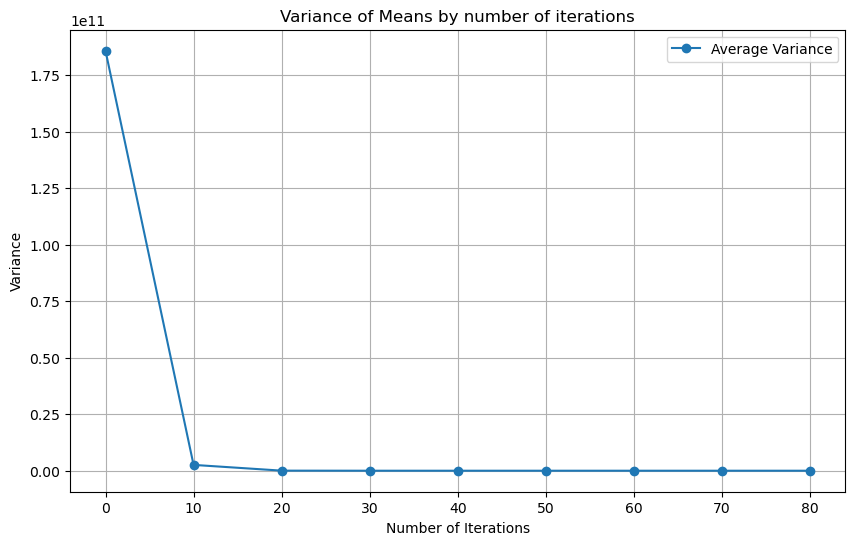

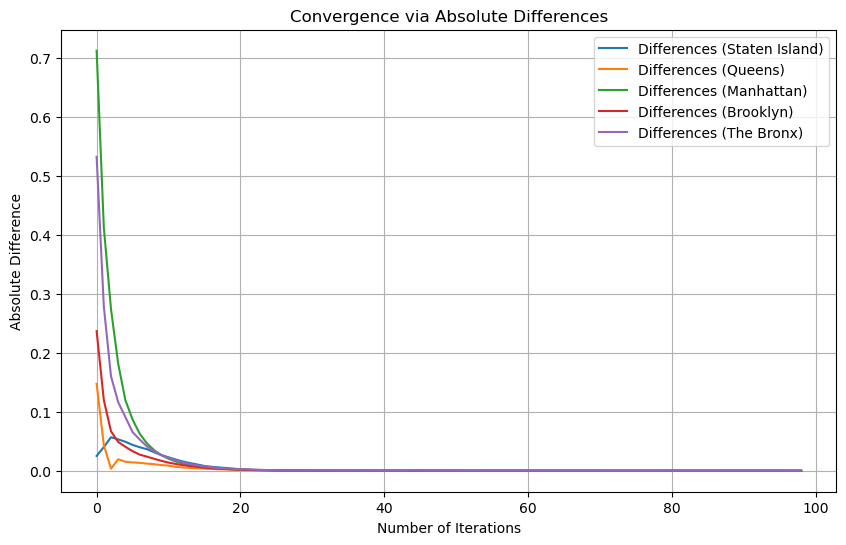

In [5]:
# Determine the x values (row indices)
x_values = np.arange(iteration_tests_same.shape[0])

# Plot each column
plt.figure(figsize=(10, 6))
for col in range(iteration_tests_same.shape[1]):
    plt.plot(x_values, iteration_tests_same[:, col], label=f'{yearly_prices.columns[col]}')

# Add labels, legend, and grid
plt.xlabel('Number of Iterations')
plt.ylabel('Average Property Value')
plt.title('Impact of number of iterations on Housing Agent Model')
plt.legend()
plt.grid(True)
plt.show()


# Variance over intervals
interval = 10
variances = [np.var(iteration_tests_same[i:i+interval, :], axis=0) for i in range(0, len(iteration_tests_same) - interval, interval)]

# Plot variance over intervals
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(variances)) * interval, np.mean(variances, axis=1), '-o', label='Average Variance')
plt.xlabel('Number of Iterations')
plt.ylabel('Variance')
plt.title('Variance of Means by number of iterations')
plt.legend()
plt.grid(True)
plt.show()

# Plot absolute differences
abs_differences = np.abs(np.diff(iteration_tests_same, axis=0)) / iteration_tests_same[:-1]
plt.figure(figsize=(10, 6))
for col in range(iteration_tests_same.shape[1]):
    plt.plot(x_values[:-1], abs_differences[:, col], label=f'Differences ({yearly_prices.columns[col]})')

plt.xlabel('Number of Iterations')
plt.ylabel('Absolute Difference')
plt.title('Convergence via Absolute Differences')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Calculate maximum absolute differences as percentage
abs_max_percent = np.max(abs_differences, axis=1) * 100

# Set arbitrary threshold, set to 1%
threshold = 1

for i in range(len(abs_max_percent)):
    if abs_max_percent[i] >= threshold:
        continue
    else:
        print(f'After {i} iterations, threshold satisfied with Mean Absolute Difference: {np.round(abs_max_percent[i],4)}%.')
        break

After 15 iterations, threshold satisfied with Mean Absolute Difference: 0.8038%.


## Testing if Initial Affluence (Agent) Distribution matters

Testing for different initial grids given same number of agents, amenities and also same affluence values and distributions from data. Note amenity and agent locations are the same, only changing initial affluence.

In [ ]:
# Set arbitrary year for testing
year = 2018
median_price = np.median(yearly_prices.loc[year])

# Set iteration limit based on previous result, 24 equivalent to twice a month evaluations
n_iterations = 24
    
# Affluence group parameters 
affluence_vals = np.array(income.iloc[:,0])

# Initial affluence proportions   
affluence_dist = np.array(income.iloc[:,1])
 
# Specify the number of agents and amenities to be placed
num_agents = 1000 
num_amenities = 200

# Set inflationary weights for agents and amenities
weight = 0.8

districts = list(yearly_prices.columns) 

amenity_multiplier = {
    'park': .1* median_price,
    'school': .2 * median_price,
    'supermarket': .4 * median_price,
    'landmark': .2 * median_price
}
  

# Call initialize function
affluences, model_amenities, radius, amenity_radius = hm.grid_initializer(num_agents, num_amenities, population, affluence_vals, affluence_dist, residences_reduced, amenities_df, 100)
results_array = np.zeros((len(affluences), 5))
for i in range(len(affluences)):
    
    initial_prices = hm.initial_price_dist(affluences[i], year, yearly_prices)
    # Do the first house values calculation
    vals = hm.update_house_prices(initial_prices, weight, radius, model_amenities, amenity_multiplier, amenity_radius)

    # Calculate number of agents to add at each iteration
    for j in range(n_iterations):
        vals,_, swap_tot = hm.new_iteration(vals, weight, radius, model_amenities, amenity_multiplier, amenity_radius)
        
    for k, district in enumerate(districts):
        # Select residences within each district
        vals_k = vals[vals['District'] == district]
        results_array[i, k] = np.round(np.average(vals_k['price']))



In [14]:
# Calculate column-wise statistics for last iteration
means = np.mean(results_array, axis=0)
std_devs = np.std(results_array, axis=0)
coeff_variation = std_devs / means  # Coefficient of Variation
print(f"Coefficient of Variation maximum: {np.round(np.max(coeff_variation),5)* 100}%.")
print(f"Coefficient of Variation range: {np.round(np.max(coeff_variation) - np.min(coeff_variation),5)*100}%")

Coefficient of Variation maximum: 2.398%.
Coefficient of Variation range: 1.29%


## A discrete algorithm of optimization for amenity weights.

Based on brute force and repeated observations we have noticed that $\lambda$ seems to be purely inflationary and hence hypothesise that for every sufficiently reasonable $\lambda \in [0.5,0.9]$ there exists a combination of amenity weights that will yield a global minimum for that year. Hence, due to computation constraints we limit our testing to a set $\lambda$ value of $0.8$. Then, based on the aforementioned observations we test different permutations of weights that have worked in the past for us. 

All permutations of the amenity weights $[0.1, 0.2, 0.2, 0.4]$, $[0.1, 0.2, 0.3, 0.4]$, $[0.1, 0.2, 0.4, 0.4]$, and $[0.1, 0.1, 0.2, 0.4]$ corresponding to **park**, **school**, **supermarket**, and **landmark**, respectively, were tested under $\lambda = 0.8$. These tests evaluated all distinct weight configurations to identify the approximate "best" combinations yielding a global minimum for each target year. With more computational resources, these results could serve as starting points for advanced optimization methods like Genetic Algorithms, L-BFGS-B, or other numerical techniques to refine and identify more precise weight approximations for improved model performance. We have attempted to implement these models but due to size of cartesian space numerous tests have incorrectly converged at saddle points, so these are our best approximates at the moment.

In [ ]:
# FIXED PARAMETERS

# Set arbitrary year for testing
year = 2018
median_price = np.median(yearly_prices.loc[year])

# Set iteration limit based on previous result, 24 equivalent to twice a month evaluations
n_iterations = 24
    
# Affluence group parameters 
affluence_vals = np.array(income.iloc[:,0])

# Initial affluence proportions   
affluence_dist = np.array(income.iloc[:,1])
 
# Specify the number of agents and amenities to be placed
num_agents = 1000 
num_amenities = 200

# Set inflationary weight for agents
weight = 0.8

# Convert districts to ordered list
districts = list(yearly_prices.columns) 

# Compute all desired permutations

def unique_combinations(elements):
    # Use set to automatically handle duplicates
    unique_perms = set(permutations(elements))
    return list(unique_perms)

# Example usage we get this range from previous manual testing which satisfies desirable inflation
elements_middle_repeat = [.1, .2, .2, .4]
combinations_middle_repeat = unique_combinations(elements_middle_repeat)

elements_no_repeat = [.1, .2, .3, .4]
combinations_no_repeat = unique_combinations(elements_no_repeat)

elements_edge_repeat_upper = [.1, .2, .4, .4]
combinations_edge_repeat_upper = unique_combinations(elements_edge_repeat_upper)

elements_edge_repeat_lower = [.1, .1, .2, .4]
combinations_edge_repeat_lower = unique_combinations(elements_edge_repeat_lower)

# Merge all unique combinations into a single list
all_combinations = (
    combinations_middle_repeat +
    combinations_no_repeat +
    combinations_edge_repeat_upper +
    combinations_edge_repeat_lower
)

# Convert to a set to array
all_combinations_array = np.array(all_combinations)

# Initialize grid

model_agents, model_amenities, radius, radius_amenities = hm.grid_initializer(num_agents, num_amenities, population,np.array(income.iloc[:, 0]), np.array(income.iloc[:, 1]),residences_reduced, amenities_df)

results_df = pd.DataFrame(columns=['best amenity weights', 'best MAPE'], index=yearly_prices.index[:-1])

for i in range(yearly_prices.shape[0]):
    current_year = yearly_prices.index[i]
    next_year = yearly_prices.index[i + 1]
    print(f"Optimizing for year {current_year}...")

    # Pre-set best values
    best_mape = float('inf')
    best_amenities = None
    
    initial_prices = hm.initial_price_dist(model_agents, current_year, yearly_prices)
    med_price = np.median(yearly_prices.loc[current_year])
    next_year_prices = np.array(yearly_prices.loc[next_year])
    for j in range(all_combinations_array.shape[0]):
        amenity_weights = {
        'park': all_combinations_array[j,0]* median_price,
        'school': all_combinations_array[j,1]*median_price,
        'supermarket': all_combinations_array[j,2]*median_price,
        'landmark': all_combinations_array[j,3] *median_price}
        
         # Perform simulation for n_iterations
        vals = initial_prices
        for k in range(n_iterations):
            vals, _, _ = hm.new_iteration(vals, weight, radius, model_amenities, amenity_weights, radius_amenities)
        
        # Calculate final prices
        prices_end = np.zeros(len(districts))
        for n, district in enumerate(districts):
            vals_district = vals[vals['District'] == district]
            prices_end[n] = np.round(np.average(vals_district['price']))

        # Calculate MAPE
        ape = hm.calculate_ape(prices_end, np.array(yearly_prices.loc[next_year]))
        mape = np.mean(ape)
        
        # Check if this combination yields a better MAPE
        if mape < best_mape:
            best_mape = mape
            best_amenities = all_combinations_array[j,:]
            print(f"{all_combinations_array[j,:]} improved MAPE, new best MAPE for year {current_year} = {best_mape}.")
    # Store the best parameters for the current year
    results_df.loc[current_year, 'best amenity weights'] = best_amenities
    results_df.loc[current_year, 'best MAPE'] = best_mape
# Display the results DataFrame
print(results_df)
        
    